# Machine Learning (LSTM Network) mit Python und historischen Aktienkursen der Yahoo Finance API als .csv Datei

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [37]:
# Einlesen der historischen Daten mithilfe einer .csv Datei
# Erstellen des Dataframes (df) und transformieren der Daten
df = pd.read_csv('statics/TWTR.csv')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
247,2022-06-21,38.189999,39.080002,37.660000,38.910000,38.910000,16902200
248,2022-06-22,38.570000,39.340000,38.410000,38.529999,38.529999,10823800
249,2022-06-23,38.759998,39.080002,38.250000,38.680000,38.680000,6327600
250,2022-06-24,39.009998,39.919998,38.869999,39.410000,39.410000,18084800
251,2022-06-27,39.669998,39.880001,38.900002,39.189999,39.189999,7140600


In [38]:
# Trainingsdatensatz auf 80% der Daten festlegen
train_size = int(len(df) * 0.8)
# Aufsplitten der Dataframes auf Trainings und Testdaten
df_train, df_test = df[:train_size], df[train_size:len(df)]
# Spalten 'Open' und 'High' sollen betrachtet werden, daher 1 und 2 Spalte als values auswählen
train_data = df_train.iloc[:, 1:2].values

In [39]:
# Machine Learning Funktion MinMax skaliert alle Daten zwischen dem eingestellten Intervall, hier von 0 bis 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)

In [60]:
x_train = []
y_train = []

# Time Window legt fest welcher Beobachtungszeitraum für die Vorhersage benutzt werden soll
time_window = 60

for i in range(time_window, len(train_data_scaled)):
  x_train.append(train_data_scaled[i-time_window:i, 0])
  y_train.append(train_data_scaled[i, 0])

# Umwandeln in numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Transformieren des 2-dimensionalem Arrays in ein 3-dimensionales, für die Nutzung im neuronalem Netzwerk
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [61]:
# Erstellen des LSTM Networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Aufbau: 3 LSTM Layer, 1 Dense Layer, dazwischen Dropouts um Overfitting zu vermeiden

model = Sequential()
# 1. Schicht, return_sequences besagt das Informationen behalten und nicht nur wie bei Feed Forward weiter gegeben werden 
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# Dropout(0.2) deaktiviert zufällig Neuronen mit einer Rate von 0.2
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# Dense Layer stellt Output Layer dar
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
5/5 [==============================] - 4s 50ms/step - loss: 0.1176
Epoch 2/25
5/5 [==============================] - 0s 45ms/step - loss: 0.0351
Epoch 3/25
5/5 [==============================] - 0s 46ms/step - loss: 0.0269
Epoch 4/25
5/5 [==============================] - 0s 49ms/step - loss: 0.0217
Epoch 5/25
5/5 [==============================] - 0s 45ms/step - loss: 0.0169
Epoch 6/25
5/5 [==============================] - 0s 45ms/step - loss: 0.0164
Epoch 7/25
5/5 [==============================] - 0s 44ms/step - loss: 0.0175
Epoch 8/25
5/5 [==============================] - 0s 48ms/step - loss: 0.0111
Epoch 9/25
5/5 [==============================] - 0s 56ms/step - loss: 0.0122
Epoch 10/25
5/5 [==============================] - 0s 49ms/step - loss: 0.0142
Epoch 11/25
5/5 [==============================] - 0s 46ms/step - loss: 0.0105
Epoch 12/25
5/5 [==============================] - 0s 47ms/step - loss: 0.0146
Epoch 13/25
5/5 [==============================] - 0s 47ms/st

In [62]:
actual_stock_price = df_test.iloc[:, 1:2].values

total_data = pd.concat((df_train['Open'], df_test['Open']), axis=0)
test_data = total_data[len(total_data)-len(df_test)-time_window:].values
test_data = test_data.reshape(-1, 1)
test_data = scaler.transform(test_data)

In [63]:
total_dates = pd.concat((df_train['Date'], df_test['Date']), axis=0)
test_dates = total_dates[len(total_dates)-len(df_test)-time_window:].values
test_dates = test_dates.reshape(-1, 1)

In [64]:
x_test = []
for i in range(time_window, len(test_data)):
  x_test.append(test_data[i-time_window:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [65]:
predicted_stock_price = model.predict(x_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

2/2 [==============================] - 1s 13ms/step


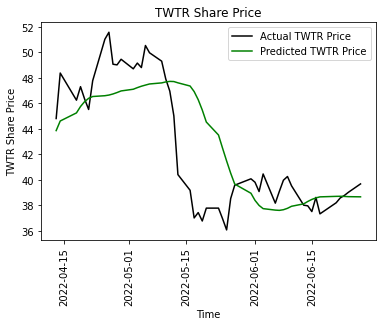

In [66]:
import datetime as dt

plt_test_dates = [dt.datetime.strptime(d, '%Y-%m-%d') for d in test_dates[time_window:, 0]]
plt.plot(plt_test_dates, actual_stock_price[:, 0], color='black', label='Actual TWTR Price')
plt.plot(plt_test_dates, predicted_stock_price[:, 0], color='green', label='Predicted TWTR Price')
plt.xticks(rotation=90)
plt.title('TWTR Share Price')
plt.xlabel('Time')
plt.ylabel('TWTR Share Price')
plt.legend()
plt.show()

In [67]:
real_data = [test_data[len(test_data)+1-time_window:len(test_data+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Prediction: {prediction}')

1/1 [==============================] - 1s 824ms/step
Prediction: [[38.661045]]
